In [1]:
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import polars as pl
import scipy

In [2]:
import torch
from torch.utils.data import Dataset
import torchvision
import torch.nn.functional as F

/home/takateru/miniconda3/envs/myenv1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from transformers import ConvNextV2Config, ConvNextV2ForImageClassification

In [4]:
from sklearn.linear_model import LogisticRegressionCV
def regression_control(scores, split, seed, csize):
    rng = np.random.default_rng(seed)
    wtdata = scores['wta'][rng.permutation(len(scores['wta']))[:np.sum(split)]]
    tgdata = scores['j20a'][rng.permutation(len(scores['j20a']))[:np.sum(split)]]

    trn_wt = np.empty((split[0],2))
    trn_wt[:,0] = wtdata[:split[0]][:,6]
    trn_wt[:,1] = wtdata[:split[0]][:,4]

    tst_wt = np.empty((split[1],2))
    tst_wt[:,0] = wtdata[split[0]:][:,6]
    tst_wt[:,1] = wtdata[split[0]:][:,4]

    trn_tg = np.empty((split[0],2))
    trn_tg[:,0] = tgdata[:split[0]][:,6]
    trn_tg[:,1] = tgdata[:split[0]][:,4]

    tst_tg = np.empty((split[1],2))
    tst_tg[:,0] = tgdata[split[0]:][:,6]
    tst_tg[:,1] = tgdata[split[0]:][:,4]

    assert trn_wt.shape[0]%csize == 0 and trn_tg.shape[0]%csize == 0
    trn_wt = trn_wt.reshape(trn_wt.shape[0]//csize, csize, *trn_wt.shape[1:])
    trn_tg = trn_tg.reshape(trn_tg.shape[0]//csize, csize, *trn_tg.shape[1:])
    trn_wt = trn_wt.reshape(trn_wt.shape[0],-1)
    trn_tg = trn_tg.reshape(trn_tg.shape[0],-1)
    trn_data = np.vstack((trn_wt, trn_tg))
    trn_labs = np.array([0]*(split[0]//csize)+[1]*(split[0]//csize))

    assert tst_wt.shape[0]%csize == 0 and tst_tg.shape[0]%csize == 0
    tst_wt = tst_wt.reshape(tst_wt.shape[0]//csize, csize, *tst_wt.shape[1:])
    tst_tg = tst_tg.reshape(tst_tg.shape[0]//csize, csize, *tst_tg.shape[1:])
    tst_wt = tst_wt.reshape(tst_wt.shape[0],-1)
    tst_tg = tst_tg.reshape(tst_tg.shape[0],-1)
    tst_data = np.vstack((tst_wt, tst_tg))
    tst_labs = np.array([0]*(split[1]//csize)+[1]*(split[1]//csize))

    clf = LogisticRegressionCV(cv=5,Cs=np.logspace(-10,4,15)).fit(trn_data, trn_labs)
    assert clf.C_ != 1e-10 and clf.C_ != 1e4, clf.C_
    return clf.score(tst_data, tst_labs)

In [5]:
res = 35
sigma = 0
edge = 0.0
bsize=64
hsize=20
psize=3
csize=1
lr=1e-5
acc_cnn = []
for seed in range(1000,3000,100):
    modelname = f'{res}-{sigma}-{edge}_{bsize}-100-100_{hsize}-{psize}-{csize}_{lr}_{seed}'
    stats = np.load(f'data/classifier/{modelname}/stats.npz')
    acc_cnn.append(stats['tst_acc'].item())
acc_cnn = np.array(acc_cnn)

In [6]:
run_ID = '35-0-0.0'
fname = f'data/rmaps/{run_ID}/fpspeccorr.npz'
print(f'Loaded {fname} --- Last modified at {time.ctime(os.stat(fname).st_mtime)}')
fpspeccorr = np.load(fname)

fname = f'data/rmaps/{run_ID}/fpspeccorr_new.npz'
print(f'Loaded {fname} --- Last modified at {time.ctime(os.stat(fname).st_mtime)}')
fpspeccorr_new = np.load(fname)

fname = f'data/rmaps/{run_ID}/fpautocorr.npz'
print(f'Loaded {fname} --- Last modified at {time.ctime(os.stat(fname).st_mtime)}')
fpautocorr = np.load(fname)

score_dict = {'fpspeccorr': fpspeccorr, 'fpspeccorr_new': fpspeccorr_new, 'fpautocorr': fpautocorr}
split = [800,100]

Loaded data/rmaps/35-0-0.0/fpspeccorr.npz --- Last modified at Thu May 23 11:46:01 2024
Loaded data/rmaps/35-0-0.0/fpspeccorr_new.npz --- Last modified at Thu May 23 11:46:01 2024
Loaded data/rmaps/35-0-0.0/fpautocorr.npz --- Last modified at Thu May 23 11:46:01 2024


In [7]:
acc_lin = {}
for score_type, scores in score_dict.items():
    acc_lin[score_type] = []
    for seed in range(1000,3000,100):
        acc_lin[score_type].append(regression_control(scores, split, seed, csize=1))
    acc_lin[score_type] = np.array(acc_lin[score_type])

In [8]:
np.mean(acc_cnn), np.std(acc_cnn), np.max(acc_cnn), scipy.stats.ttest_1samp(acc_cnn, popmean=0.5)

(0.6287499999999999,
 0.02919225068404286,
 0.69,
 TtestResult(statistic=19.224562198201127, pvalue=6.527316899253334e-14, df=19))

In [9]:
for score_type in score_dict.keys():
    print(np.mean(acc_lin[score_type]), np.std(acc_lin[score_type]), np.max(acc_lin[score_type]), scipy.stats.ttest_1samp(acc_lin[score_type], popmean=0.5))

0.5682499999999999 0.03857703332295006 0.63 TtestResult(statistic=7.711708943664843, pvalue=2.8781243807742637e-07, df=19)
0.5422499999999999 0.02943106352138841 0.595 TtestResult(statistic=6.257452444107433, pvalue=5.220624923927259e-06, df=19)
0.5389999999999999 0.030765240125830304 0.615 TtestResult(statistic=5.525621061392512, pvalue=2.491805009147077e-05, df=19)


In [10]:
print(scipy.stats.f_oneway(acc_cnn,acc_lin['fpspeccorr']))
print(scipy.stats.f_oneway(acc_cnn,acc_lin['fpspeccorr_new']))
print(scipy.stats.f_oneway(acc_cnn,acc_lin['fpautocorr']))
print(scipy.stats.f_oneway(acc_lin['fpspeccorr'],acc_lin['fpspeccorr_new']))
print(scipy.stats.f_oneway(acc_lin['fpspeccorr'],acc_lin['fpautocorr']))
print(scipy.stats.f_oneway(acc_lin['fpspeccorr_new'],acc_lin['fpautocorr']))

F_onewayResult(statistic=29.71521657853975, pvalue=3.2205592959199336e-06)
F_onewayResult(statistic=82.73092311049683, pvalue=4.4436996130642064e-11)
F_onewayResult(statistic=85.08770283887556, pvalue=3.065122294024555e-11)
F_onewayResult(statistic=5.455375630475186, pvalue=0.024886575124682352)
F_onewayResult(statistic=6.676703889102818, pvalue=0.013737194625682824)
F_onewayResult(statistic=0.11071268489466597, pvalue=0.7411629477909811)


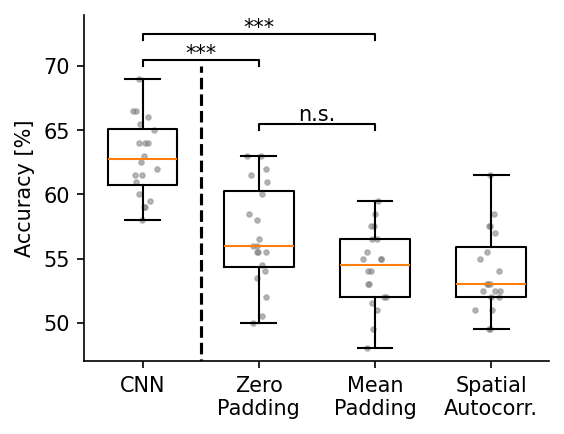

In [29]:
fig, ax = plt.subplots(1,1,figsize=(4,3),dpi=150)
ax.boxplot([acc_cnn*100,acc_lin['fpspeccorr']*100,acc_lin['fpspeccorr_new']*100,acc_lin['fpautocorr']*100],
           labels=['CNN','Zero\nPadding','Mean\nPadding', 'Spatial\nAutocorr.'],widths=0.6)
ax.scatter(1+0.05*np.random.randn(20),acc_cnn*100,s=5,color='gray',alpha=0.5)
ax.scatter(2+0.05*np.random.randn(20),acc_lin['fpspeccorr']*100,s=5,color='gray',alpha=0.5)
ax.scatter(3+0.05*np.random.randn(20),acc_lin['fpspeccorr_new']*100,s=5,color='gray',alpha=0.5)
ax.scatter(4+0.05*np.random.randn(20),acc_lin['fpautocorr']*100,s=5,color='gray',alpha=0.5)
ax.plot([1,1,2,2],[70,70.5,70.5,70],color='black',linewidth=1)
ax.plot([1,1,3,3],[72,72.5,72.5,72],color='black',linewidth=1)
ax.plot([2,2,3,3],[65,65.5,65.5,65],color='black',linewidth=1)
ax.text(1.5,71,'***',horizontalalignment='center',verticalalignment='center')
ax.text(2,73,'***',horizontalalignment='center',verticalalignment='center')
ax.text(2.5,66.2,'n.s.',horizontalalignment='center',verticalalignment='center')

ax.set_ylim([47,74])
ax.vlines(x=1.5,ymin=45,ymax=70,color='black',linestyles='--')
ax.set_ylabel('Accuracy [%]')
sns.despine(ax=ax)
fig.savefig('images/presentation/cnn/acc.png',bbox_inches='tight')

In [33]:
sns.color_palette('colorblind').as_hex()[:2]

['#0173b2', '#de8f05']

In [ ]:
'''
head = ['res','sigma','edge','hsize','psize','lr','bsize','t','loss','acc']
csv_data = []
for hsize in [5,10,20,40]:
    for lr in [1e-5,1e-4,1e-3]:
        for bsize in [32,64]:
            for psize in [3]:
                res, sigma, edge = 35, 0, 0.0
                modelname = f'{res}-{sigma}-{edge}_{bsize}-100-100_{hsize}-{psize}_{lr}'
                stats = np.load(f'data/classifier/{modelname}/stats.npz')
                for t, (loss, acc) in enumerate(zip(stats['val_loss'], stats['val_acc'])):
                    csv_data.append([res, sigma, edge, hsize, psize, lr, bsize, t, loss, acc])
            for psize in [3,7]:
                res, sigma, edge = 65, 5, 0.0
                modelname = f'{res}-{sigma}-{edge}_{bsize}-100-100_{hsize}-{psize}_{lr}'
                stats = np.load(f'data/classifier/{modelname}/stats.npz')
                for t, (loss, acc) in enumerate(zip(stats['val_loss'], stats['val_acc'])):
                    csv_data.append([res, sigma, edge, hsize, psize, lr, bsize, t, loss, acc])
df = pl.DataFrame(data=csv_data, schema=head)
'''

In [ ]:
'''
seed = 1
psize = 3
csize = 10
head = ['res','sigma','edge','hsize','psize','csize','lr','seed','bsize','t','loss','acc']
csv_data = []
for hsize in [5,10,20,40]:
    for lr in [1e-5,1e-4,1e-3]:
        for bsize in [16,32]:    
            res, sigma, edge = 35, 0, 0.0
            modelname = f'{res}-{sigma}-{edge}_{bsize}-100-100_{hsize}-{psize}-{csize}_{lr}_{seed}'
            stats = np.load(f'data/classifier/{modelname}/stats.npz')
            for t, (loss, acc) in enumerate(zip(stats['val_loss'], stats['val_acc'])):
                csv_data.append([res, sigma, edge, hsize, psize, csize, lr, seed, bsize, t, loss, acc])
df = pl.DataFrame(data=csv_data, schema=head)
'''

In [ ]:
'''
seed = 1
psize = 3
csize = 10
bsize = 32
head = ['res','sigma','edge','hsize','psize','csize','lr','seed','bsize','t','loss','acc']
csv_data = []
for seed in [100,200,300,400,500]:
    for hsize in [40,80]:
        for lr in [1e-6,1e-5]:
            res, sigma, edge = 35, 0, 0.0
            modelname = f'{res}-{sigma}-{edge}_{bsize}-100-100_{hsize}-{psize}-{csize}_{lr}_{seed}'
            stats = np.load(f'data/classifier/{modelname}/stats.npz')
            for t, (loss, acc) in enumerate(zip(stats['val_loss'], stats['val_acc'])):
                csv_data.append([res, sigma, edge, hsize, psize, csize, lr, seed, bsize, t, loss, acc])
df = pl.DataFrame(data=csv_data, schema=head)
'''

In [ ]:
'''
psize = 3
head = ['res','sigma','edge','hsize','psize','csize','lr','seed','bsize','t','loss','acc']
csv_data = []
for sigma in [0,2]:
    for seed in [100,200,300]:
        for hsize in [20,40,80]:
            for lr in [1e-6,1e-5]:
                res, edge = 35, 0.0
                csize, bsize = 1, 64
                modelname = f'{res}-{sigma}-{edge}_{bsize}-100-100_{hsize}-{psize}-{csize}_{lr}_{seed}'
                stats = np.load(f'data/classifier/{modelname}/stats.npz')
                for t, (loss, acc) in enumerate(zip(stats['val_loss'], stats['val_acc'])):
                    csv_data.append([res, sigma, edge, hsize, psize, csize, lr, seed, bsize, t, loss, acc])

                csize, bsize = 10, 8
                modelname = f'{res}-{sigma}-{edge}_{bsize}-100-100_{hsize}-{psize}-{csize}_{lr}_{seed}'
                stats = np.load(f'data/classifier/{modelname}/stats.npz')
                for t, (loss, acc) in enumerate(zip(stats['val_loss'], stats['val_acc'])):
                    csv_data.append([res, sigma, edge, hsize, psize, csize, lr, seed, bsize, t, loss, acc])
df = pl.DataFrame(data=csv_data, schema=head)
'''

In [82]:
psize = 3
head = ['res','sigma','edge','hsize','psize','csize','lr','seed','bsize','t','loss']
csv_data = []
res, sigma, edge = 35, 0, 0.0
for seed in range(1000,3000,100):
    for lr in [1e-5]:
        csize, hsize, bsize = 1, 20, 64
        modelname = f'{res}-{sigma}-{edge}_{bsize}-100-100_{hsize}-{psize}-{csize}_{lr}_{seed}'
        stats = np.load(f'data/classifier/{modelname}/stats.npz')
        for t, loss in enumerate(stats['val_loss']):
            csv_data.append([res, sigma, edge, hsize, psize, csize, lr, seed, bsize, t, loss])
df = pl.DataFrame(data=csv_data, schema=head)
df

res,sigma,edge,hsize,psize,csize,lr,seed,bsize,t,loss
i64,i64,f64,i64,i64,i64,f64,i64,i64,i64,f64
35,0,0.0,20,3,1,0.00001,1000,64,0,1.374217
35,0,0.0,20,3,1,0.00001,1000,64,1,1.368098
35,0,0.0,20,3,1,0.00001,1000,64,2,1.364635
35,0,0.0,20,3,1,0.00001,1000,64,3,1.360834
35,0,0.0,20,3,1,0.00001,1000,64,4,1.355504
…,…,…,…,…,…,…,…,…,…,…
35,0,0.0,20,3,1,0.00001,2900,64,45,1.391691
35,0,0.0,20,3,1,0.00001,2900,64,46,1.384584
35,0,0.0,20,3,1,0.00001,2900,64,47,1.390523


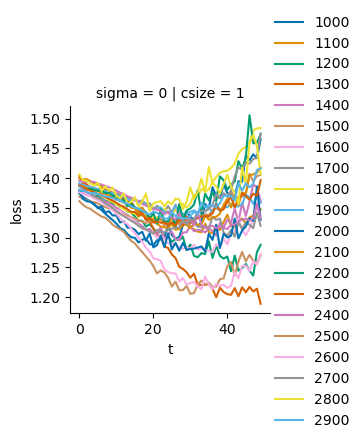

In [83]:
sigma = 0
g = sns.FacetGrid(data=df.filter(pl.col('lr')==1e-5),col='csize',row='sigma',sharex=True,sharey=False)
g.map_dataframe(sns.lineplot, x='t', y='loss', hue='seed',palette='colorblind')
g.add_legend()

In [95]:
psize = 3
val_label = 'trn_loss'
head = ['res','sigma','edge','hsize','psize','csize','lr','seed','bsize','t','val']
csv_data = []
res, sigma, edge = 35, 0, 0.0
for seed in [100,200,300]:
    for lr in [1e-6,1e-5]:
        csize, hsize, bsize = 2, 40, 32
        modelname = f'{res}-{sigma}-{edge}_{bsize}-100-100_{hsize}-{psize}-{csize}_{lr}_{seed}'
        stats = np.load(f'data/classifier/{modelname}/stats.npz')
        for t, loss in enumerate(stats[val_label]):
            csv_data.append([res, sigma, edge, hsize, psize, csize, lr, seed, bsize, t, loss])

        csize, hsize, bsize = 5, 100, 16
        modelname = f'{res}-{sigma}-{edge}_{bsize}-100-100_{hsize}-{psize}-{csize}_{lr}_{seed}'
        stats = np.load(f'data/classifier/{modelname}/stats.npz')
        for t, loss in enumerate(stats[val_label]):
            csv_data.append([res, sigma, edge, hsize, psize, csize, lr, seed, bsize, t, loss])

        csize, hsize, bsize = 10, 200, 5
        modelname = f'{res}-{sigma}-{edge}_{bsize}-100-100_{hsize}-{psize}-{csize}_{lr}_{seed}'
        stats = np.load(f'data/classifier/{modelname}/stats.npz')
        for t, loss in enumerate(stats[val_label]):
            csv_data.append([res, sigma, edge, hsize, psize, csize, lr, seed, bsize, t, loss])

        csize, hsize, bsize = 25, 500, 2
        modelname = f'{res}-{sigma}-{edge}_{bsize}-100-100_{hsize}-{psize}-{csize}_{lr}_{seed}'
        stats = np.load(f'data/classifier/{modelname}/stats.npz')
        for t, loss in enumerate(stats[val_label]):
            csv_data.append([res, sigma, edge, hsize, psize, csize, lr, seed, bsize, t, loss])
df = pl.DataFrame(data=csv_data, schema=head)
df

res,sigma,edge,hsize,psize,csize,lr,seed,bsize,t,val
i64,i64,f64,i64,i64,i64,f64,i64,i64,i64,f64
35,0,0.0,40,3,2,0.000001,100,32,0,15.443727
35,0,0.0,40,3,2,0.000001,100,32,1,15.371307
35,0,0.0,40,3,2,0.000001,100,32,2,15.377218
35,0,0.0,40,3,2,0.000001,100,32,3,15.282032
35,0,0.0,40,3,2,0.000001,100,32,4,15.252659
…,…,…,…,…,…,…,…,…,…,…
35,0,0.0,500,3,25,0.00001,300,2,45,19.266838
35,0,0.0,500,3,25,0.00001,300,2,46,12.19572
35,0,0.0,500,3,25,0.00001,300,2,47,16.035157


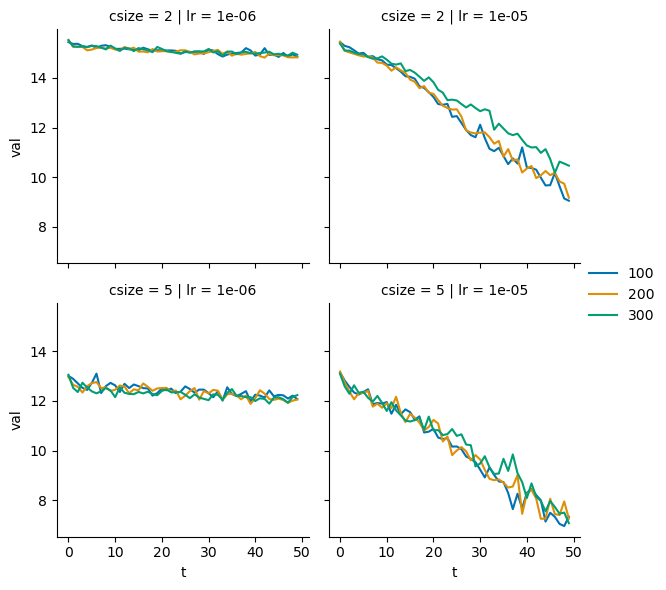

In [96]:
sigma = 0
g = sns.FacetGrid(data=df.filter(pl.col('csize')<10),row='csize',col='lr',sharex=True,sharey=True)
g.map_dataframe(sns.lineplot, x='t', y='val', hue='seed',palette='colorblind')
g.add_legend()

In [71]:
res = 35
sigma = 0
edge = 0.0
bsize=32
hsize=40
psize=3
csize=2
lr=1e-5
acc = []
for seed in [100,200,300]:
    modelname = f'{res}-{sigma}-{edge}_{bsize}-100-100_{hsize}-{psize}-{csize}_{lr}_{seed}'
    stats = np.load(f'data/classifier/{modelname}/stats.npz')
    acc.append(stats['tst_acc'].item())

In [72]:
np.mean(acc)

0.5866666666666668

In [73]:
acc

[0.56, 0.56, 0.64]

In [76]:
acc_cnn

[0.59,
 0.65,
 0.69,
 0.66,
 0.61,
 0.64,
 0.58,
 0.615,
 0.62,
 0.64,
 0.595,
 0.64,
 0.665,
 0.665,
 0.625,
 0.63,
 0.655,
 0.615,
 0.6,
 0.59]

## CNN

In [6]:
from transformers import ConvNextV2Config, ConvNextV2ForImageClassification

In [7]:
res = 35
sigma = 0
edge = 0.0
bsize=64
hsize=20
psize=3
csize=1
lr=1e-5
acc_cnn = []
for seed in range(1000,3000,100):
    modelname = f'{res}-{sigma}-{edge}_{bsize}-100-100_{hsize}-{psize}-{csize}_{lr}_{seed}'
    stats = np.load(f'data/classifier/{modelname}/stats.npz')
    acc_cnn.append(stats['tst_acc'].item())
acc_cnn = np.array(acc_cnn)

In [8]:
res = 35
sigma = 0
edge = 0.0
bsize=64
hsize=20
psize=3
csize=1
lr=1e-5
seed = np.arange(1000,3000,100)[np.argsort(acc_cnn)[-1]]
modelname = f'{res}-{sigma}-{edge}_{bsize}-100-100_{hsize}-{psize}-{csize}_{lr}_{seed}'
model = ConvNextV2ForImageClassification.from_pretrained(f'data/classifier/{modelname}')

In [9]:
res = 35
sigma = 0
edge = 0.0
run_ID = f'{res}-{sigma}-{edge}'
fname = f'data/rmaps/{run_ID}/rmaps.npz'
print(f'Loaded {run_ID} --- Last modified at {time.ctime(os.stat(fname).st_mtime)}')
rmaps = np.load(fname)

Loaded 35-0-0.0 --- Last modified at Thu May 23 11:46:00 2024


In [10]:
from classifier import get_data, get_loader
trn_data, val_data, tst_data = get_data(rmaps, split=[700,100,100], seed=seed)
tst_loader = get_loader(tst_data[0], tst_data[1], 200, 1)

In [11]:
model.eval()
for data in tst_loader:
    inputs, labels = data
    with torch.no_grad():
        outputs = model(inputs,labels)
    pred = (F.softmax(outputs.logits,dim=-1)[:,1] > 0.5).to('cpu').to(float)
    print('Pass')

Pass


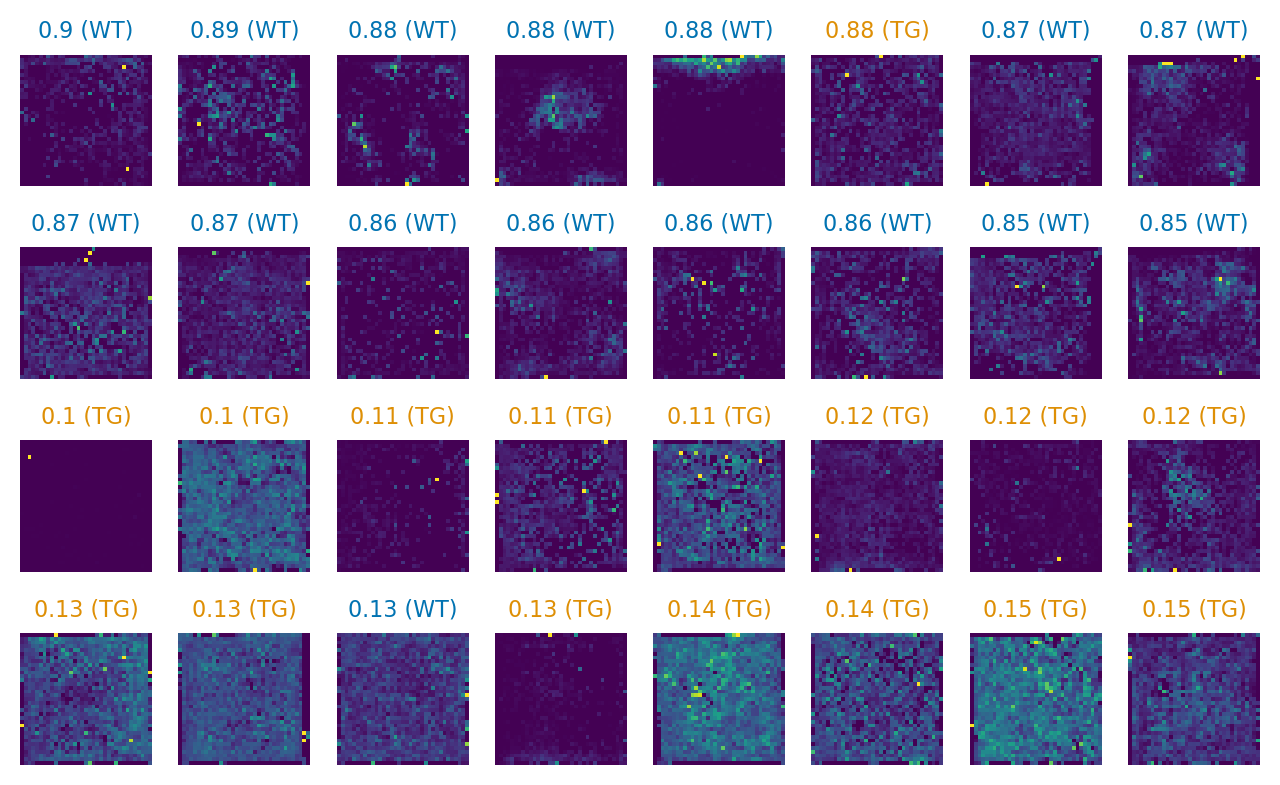

In [13]:
probs = F.softmax(outputs.logits,dim=-1)
fig, axs = plt.subplots(4,8,figsize=(8,4.8),dpi=200)

clist = sns.color_palette('colorblind')
for pid, nid in enumerate(torch.argsort(probs[:,0],descending=True)[:16]):
    ax = axs[pid//8,pid%8]
    rmap = inputs[nid][0].numpy()
    ax.imshow(rmap)
    ax.set_title(f'{probs[nid,0]:.2g} ({["WT","TG"][labels[nid].item()]})',
                 color=clist[labels[nid].item()],fontsize=8)
    ax.axis('off')

for pid, nid in enumerate(torch.argsort(probs[:,1],descending=True)[:16]):
    ax = axs[2+pid//8,pid%8]
    rmap = inputs[nid][0].numpy()
    ax.imshow(rmap)
    ax.set_title(f'{probs[nid,0]:.2g} ({["WT","TG"][labels[nid].item()]})',
                 color=clist[labels[nid].item()],fontsize=8)
    ax.axis('off')

fig.savefig(f'images/presentation/cnn/examples.png',bbox_inches='tight')